In [ ]:
%%capture

# !pip install torch-scatter -f $url
# !pip install torch-sparse -f $url
# !pip install torch-geometric
# !pip install torch-cluster -f $url
# !pip install pygod
# !pip install --upgrade scipy


In [2]:
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter


In [3]:
# Setando determinismo para reprodução do resultado
random_seed = 123
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)



## Carregando dataset

In [4]:
from torch_geometric.datasets import GitHub
dataset = GitHub(root='/tmp/github')


In [5]:
print(f"Número de Grafos: {len(dataset)}")
print(f"Número de classes de nós: {dataset.num_classes}")
print(f"Número de features: {dataset.num_node_features}")


Número de Grafos: 1
Número de classes de nós: 2
Número de features: 128


In [6]:
graph = dataset[0]

print(f"Number of nodes: {graph.x.shape[0]}")
print(f"Number of node features: {graph.x.shape[1]}")
print(f"Number of edges: {graph.edge_index.shape[1]}")



Number of nodes: 37700
Number of node features: 128
Number of edges: 578006


In [7]:
graph.x


tensor([[ 1.4799, -0.6568, -0.1793,  ..., -0.2258,  2.0619,  0.1963],
        [-0.9020, -0.6568, -0.1793,  ..., -0.2420, -0.4832, -0.2165],
        [-0.3659, -0.6568, -0.1793,  ...,  2.5961,  2.0635, -0.2165],
        ...,
        [ 1.2091, -0.6568, -0.1793,  ..., -0.2274, -0.4849, -0.2165],
        [-0.9020, -0.6551, -0.1793,  ..., -0.2420, -0.4854, -0.2079],
        [-0.9020,  1.5236, -0.1793,  ..., -0.2420, -0.4854, -0.2165]])

In [8]:
graph.edge_index.T


tensor([[    0, 23977],
        [23977,     0],
        [    1, 34526],
        ...,
        [ 2347, 25879],
        [25616,  2347],
        [ 2347, 25616]])

In [9]:
print("Distribuição das classes:")
sorted(Counter(graph.y.tolist()).items())


Distribuição das classes:


[(0, 27961), (1, 9739)]

## Visualização do grafo

In [10]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.cpu().numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(sorted(g.nodes), n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 


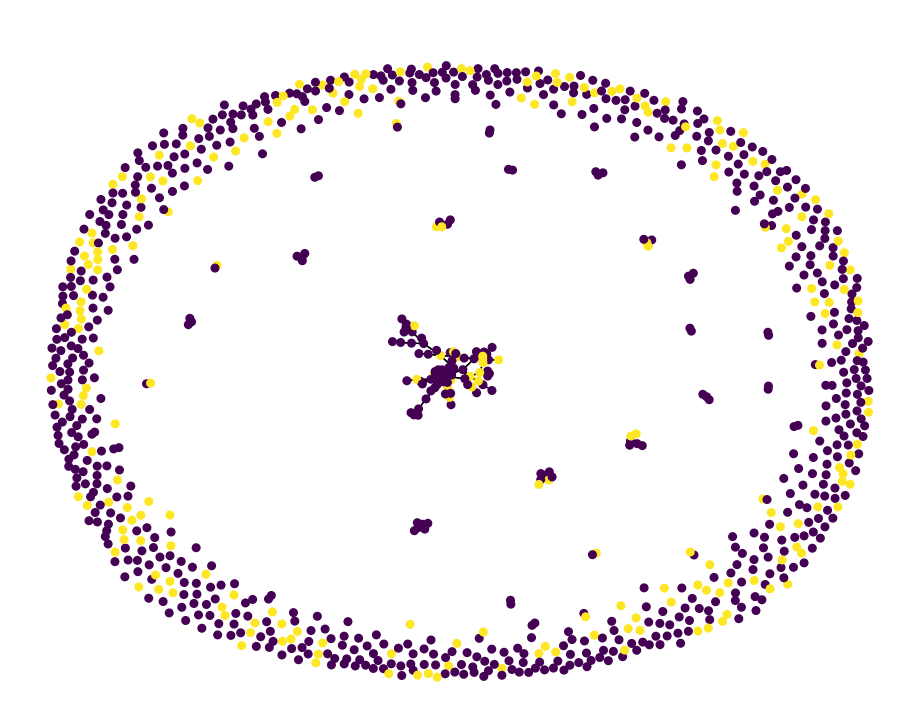

In [11]:
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)


# Classificação de Nós

In [12]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)
print(
    f"train: {int(graph.train_mask.sum())}, ",
    f"val: {int(graph.val_mask.sum())}, ",
    f"test: {int(graph.test_mask.sum())}",
)


train: 26390,  val: 3770,  test: 7540


## MLP

In [13]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output


In [14]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):
    
    train_losses = []
    val_accs = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        train_losses.append(loss.item())
        val_accs.append(acc)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model

def eval_node_classifier(model, graph, mask):
    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to(device)
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)


Epoch: 010, Train Loss: 0.374, Val Acc: 0.842
Epoch: 020, Train Loss: 0.343, Val Acc: 0.842
Epoch: 030, Train Loss: 0.327, Val Acc: 0.847
Epoch: 040, Train Loss: 0.314, Val Acc: 0.848
Epoch: 050, Train Loss: 0.300, Val Acc: 0.850
Epoch: 060, Train Loss: 0.278, Val Acc: 0.849
Epoch: 070, Train Loss: 0.249, Val Acc: 0.837
Epoch: 080, Train Loss: 0.234, Val Acc: 0.840
Epoch: 090, Train Loss: 0.203, Val Acc: 0.837
Epoch: 100, Train Loss: 0.180, Val Acc: 0.826
Epoch: 110, Train Loss: 0.168, Val Acc: 0.830
Epoch: 120, Train Loss: 0.155, Val Acc: 0.818
Epoch: 130, Train Loss: 0.152, Val Acc: 0.814
Epoch: 140, Train Loss: 0.135, Val Acc: 0.815
Epoch: 150, Train Loss: 0.124, Val Acc: 0.807


In [16]:
test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Acurácia: {test_acc:.3f}')


Acurácia: 0.805


## GCN

In [17]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        
        # Primeira mensagem
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Segunda mensagem
        output = self.conv2(x, edge_index)

        return output



In [18]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)


Epoch: 010, Train Loss: 0.368, Val Acc: 0.856
Epoch: 020, Train Loss: 0.350, Val Acc: 0.858
Epoch: 030, Train Loss: 0.332, Val Acc: 0.859
Epoch: 040, Train Loss: 0.326, Val Acc: 0.861
Epoch: 050, Train Loss: 0.321, Val Acc: 0.864
Epoch: 060, Train Loss: 0.318, Val Acc: 0.865
Epoch: 070, Train Loss: 0.315, Val Acc: 0.865
Epoch: 080, Train Loss: 0.313, Val Acc: 0.865
Epoch: 090, Train Loss: 0.311, Val Acc: 0.866
Epoch: 100, Train Loss: 0.309, Val Acc: 0.866
Epoch: 110, Train Loss: 0.308, Val Acc: 0.867
Epoch: 120, Train Loss: 0.306, Val Acc: 0.867
Epoch: 130, Train Loss: 0.304, Val Acc: 0.868
Epoch: 140, Train Loss: 0.303, Val Acc: 0.868
Epoch: 150, Train Loss: 0.301, Val Acc: 0.868
Epoch: 160, Train Loss: 0.299, Val Acc: 0.869
Epoch: 170, Train Loss: 0.298, Val Acc: 0.869
Epoch: 180, Train Loss: 0.296, Val Acc: 0.869
Epoch: 190, Train Loss: 0.295, Val Acc: 0.869
Epoch: 200, Train Loss: 0.293, Val Acc: 0.870


In [19]:
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Acurácia: {test_acc:.3f}')


Acurácia: 0.864


### Visualizando resultado de classificação

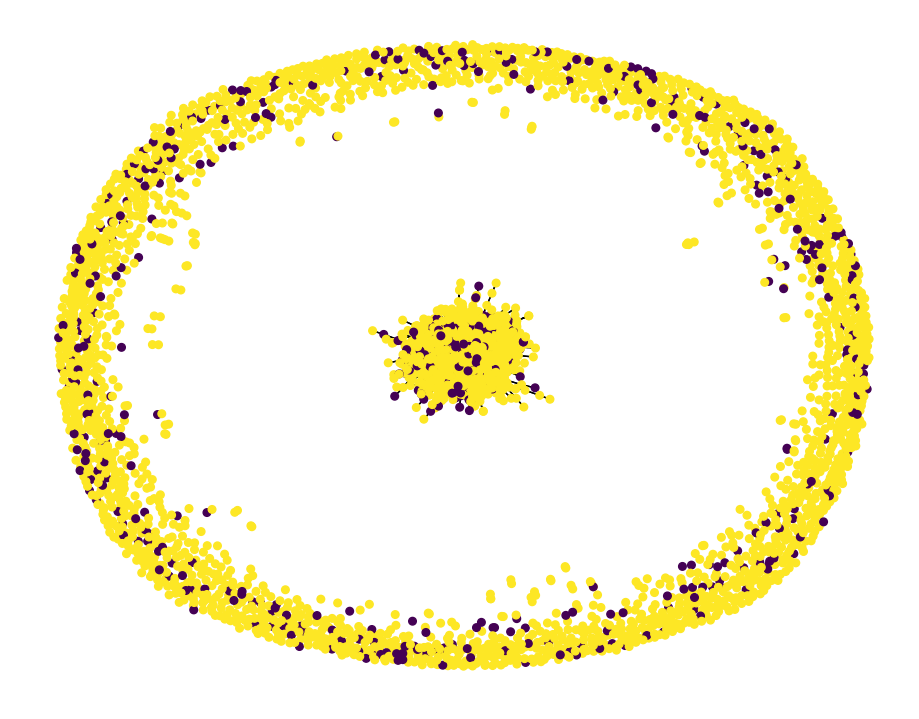

In [20]:
gcn.eval()
pred = gcn(graph).argmax(dim=1)
corrects = (pred[graph.test_mask] == graph.y[graph.test_mask]).cpu().numpy().astype(int)
test_index = np.arange(len(graph.x))[graph.test_mask.cpu().numpy()]
g, y = convert_to_networkx(graph)
g_test = g.subgraph(test_index)

plot_graph(g_test, corrects)

## Link Prediction

In [21]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


In [22]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [23]:
""" deleting node split masks """

del graph.train_mask 
del graph.val_mask 
del graph.test_mask


In [24]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)


In [25]:
print('train_data:', train_data)
print('val_data:', val_data)
print('test_data:', test_data)


train_data: Data(x=[37700, 128], edge_index=[2, 491306], y=[37700], edge_label=[245653], edge_label_index=[2, 245653])
val_data: Data(x=[37700, 128], edge_index=[2, 491306], y=[37700], edge_label=[28900], edge_label_index=[2, 28900])
test_data: Data(x=[37700, 128], edge_index=[2, 520206], y=[37700], edge_label=[57800], edge_label_index=[2, 57800])


In [26]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

model = train_link_predictor(model, train_data, val_data, optimizer, criterion)


Epoch: 010, Train Loss: 0.496, Val AUC: 0.921
Epoch: 020, Train Loss: 0.459, Val AUC: 0.924
Epoch: 030, Train Loss: 0.443, Val AUC: 0.925
Epoch: 040, Train Loss: 0.434, Val AUC: 0.925
Epoch: 050, Train Loss: 0.430, Val AUC: 0.924
Epoch: 060, Train Loss: 0.426, Val AUC: 0.924
Epoch: 070, Train Loss: 0.423, Val AUC: 0.925
Epoch: 080, Train Loss: 0.421, Val AUC: 0.924
Epoch: 090, Train Loss: 0.422, Val AUC: 0.907
Epoch: 100, Train Loss: 0.419, Val AUC: 0.930


In [27]:
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")


Test: 0.928


## Detecção de anomalia

In [28]:
from pygod.utils import load_data

# graph = load_data('inj_cora').to(device)
graph = dataset[0]

from pygod.detector import DOMINANT
from sklearn.metrics import roc_auc_score, average_precision_score

graph.y = graph.y.bool()
model = DOMINANT()
model = model.fit(graph)
outlier_scores = model.decision_function(graph)
auc = roc_auc_score(graph.y.cpu().numpy(), outlier_scores)
ap = average_precision_score(graph.y.cpu().numpy(), outlier_scores)
print(f'AUC Score: {auc:.3f}')
print(f'AP Score: {ap:.3f}')


Number of nodes: 37700
Number of node features: 128
Number of edges: 578006
